In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import pybedtools as pbt
import matplotlib.pyplot as plt
import fanc
import fanc.plotting as fancplot

%matplotlib inline

In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be remove

In [2]:
ES = fanc.load("../data/bonev/HiC/ES_mapq30/ES_mapq30.hic@25000@KR")
NPC = fanc.load("../data/bonev/HiC/NPC_mapq30/NPC_mapq30.hic@25000@KR")
CN = fanc.load("../data/bonev/HiC/CN_mapq30/CN_mapq30.hic@25000@KR")

In [3]:
NPC_insulation_prefix = "7-BS_range/NPC"
CN_insulation_prefix = "7-BS_range/CN"
window_sizes = 250000

In [4]:
NPC_insulation = fanc.InsulationScores.from_hic(NPC,window_sizes=window_sizes,file_name="{}.ins".format(NPC_insulation_prefix))
NPC_boundaries = fanc.Boundaries.from_insulation_score(NPC_insulation,window_size=window_sizes)
NPC_boundaries.to_bed("{}_boundaries.bed".format(NPC_insulation_prefix))

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/fanc/architecture/domains.py:410: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/fanc/tools/matrix.py:76: UserWarning: Warning: converting a masked element to nan.
  delta[i] = np.ma.mean(x[down_slice] - x[i]) - np.ma.mean(x[up_slice] - x[i])
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/fanc/architecture/maxima_callers.py:96: RuntimeWarning: invalid value encountered in greater
  self._min_mask = getitem_interpolated(self.delta_d1, self._peaks) > 0


In [5]:
CN_insulation = fanc.InsulationScores.from_hic(CN,window_sizes=window_sizes,file_name="{}.ins".format(CN_insulation_prefix))
CN_boundaries = fanc.Boundaries.from_insulation_score(CN_insulation,window_size=window_sizes)
CN_boundaries.to_bed("{}_boundaries.bed".format(CN_insulation_prefix))

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/fanc/architecture/domains.py:410: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/fanc/tools/matrix.py:76: UserWarning: Warning: converting a masked element to nan.
  delta[i] = np.ma.mean(x[down_slice] - x[i]) - np.ma.mean(x[up_slice] - x[i])
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/fanc/architecture/maxima_callers.py:96: RuntimeWarning: invalid value encountered in greater
  self._min_mask = getitem_interpolated(self.delta_d1, self._peaks) > 0


In [31]:
ES_boundaries = pd.read_csv("2.CTCF-insulation/Bonev_mESc_25kb_iw250kb_boundaries.bed",
                            sep="\t",
                            header=None,
                            usecols=[0,1,2,4],
                            names=["chrom","start","end","BS"])
ES_boundaries["experiment"] = "ES"

NPC_boundaries = pd.read_csv("7-BS_range/NPC_boundaries.bed",
                            sep="\t",
                            header=None,
                            usecols=[0,1,2,4],
                            names=["chrom","start","end","BS"])
NPC_boundaries["experiment"] = "NPC"

CN_boundaries = pd.read_csv("7-BS_range/CN_boundaries.bed",
                            sep="\t",
                            header=None,
                            usecols=[0,1,2,4],
                            names=["chrom","start","end","BS"])
CN_boundaries["experiment"] = "CN"

Boundaries = pd.concat([ES_boundaries,NPC_boundaries,CN_boundaries])

In [33]:
lowCov = pd.read_csv("1-FilterLowCoverage/HiC_mESC_Bonev_25kb_blacklist.bed",sep="\t",header=None,names=["chrom","start","end"])
lowCov["chrom"] = lowCov["chrom"].str.extract("chr([1-9XY]*)")
lowCov = lowCov.query("chrom!=''").copy()

In [34]:
cols = Boundaries.columns.tolist()
Boundaries = (pbt.BedTool().from_dataframe(Boundaries).
              intersect(pbt.BedTool().from_dataframe(lowCov).slop(b=window_sizes,g="../data/genomes/mm10.big.ensembl.sizes"),v=True).
              to_dataframe(names=cols))

In [1]:
bs_dict = {"R1F2":0.817877,
           "F1F2":0.373763,
           "DelBs":0.989571,
           "R1_4":0.806303,
           "F1F2inv":0.392117,
           "ALL":0.178191}

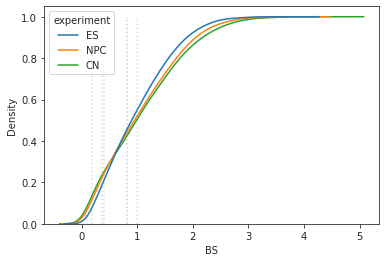

In [52]:
sns.kdeplot(data=Boundaries,x="BS",hue="experiment",cumulative=True,common_norm=False,)
plt.vlines(bs_dict.values(),0,1,linestyles="dotted",color="gainsboro")
plt.savefig("figurePlots/BS_range_cumulative.pdf")

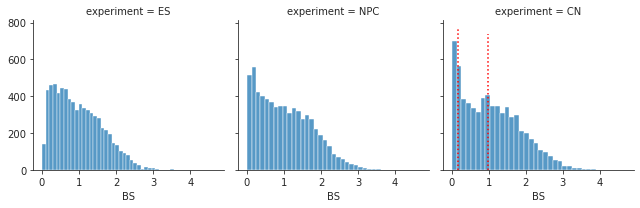

In [54]:
g = sns.FacetGrid(Boundaries, col="experiment")
g.map(sns.histplot, "BS")
plt.vlines(max(bs_dict.values()),*plt.ylim(),linestyles="dotted",color="red")
plt.vlines(min(bs_dict.values()),*plt.ylim(),linestyles="dotted",color="red")
plt.savefig("figurePlots/BS_range_histogram.pdf")

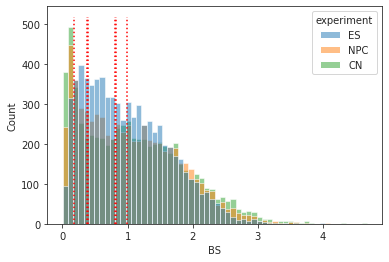

In [47]:
sns.histplot(data=Boundaries,x="BS",hue="experiment",cumulative=False,common_norm=False,)
plt.vlines(bs_dict.values(),*plt.ylim(),linestyles="dotted",color="red")